# Analysis of Eigenstate and eigenvector thought exact diagonalization

In [112]:
import pennylane as qml
import numpy as np
from jax import vmap, jit
import jax.numpy as jnp
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import copy

System studied:

$$H(L,K) = - J_1\Big( \underbrace{L \Sigma_i \sigma_z^i}_\text{magnetic field int.} + \overbrace{\Sigma_i \sigma_x^i\sigma_x^{i+1}}^\text{nearest neighbour int.} + \underbrace{K \Sigma_i \sigma_x^i\sigma_x^{i+2}}_\text{next nearest neighbour int.} \Big) \qquad\left[{J_1}\equiv 1, L:=\frac{h}{J_1}, K:= \frac{J_2}{J_1}, L\in[0,2], K = [0, -1]\right]$$

Note : In the code below $K$ (or $\kappa$) is always non-negative, the definition of it is opposite! 

In [150]:
def get_H(N, L, K, J1 : float = 1.) -> NDArray:
    # Interaction of spins with magnetic field
    H = L * qml.PauliZ(0)
    for i in range(1, N):
        H = H + (L * qml.PauliZ(i))

    # Interaction between spins (neighbouring):
    for i in range(0, N - 1):
        H = H + (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Interaction between spins (next-neighbouring):
    for i in range(0, N - 2):
        H = H + (K * (qml.PauliX(i) @ qml.PauliX(i + 2)))

    H = -J1 * H

    return jnp.array(qml.matrix(H))

def get_eigs(H : NDArray, max_e_lvl : int = 0):
    eigvals, eigvecs = jnp.linalg.eigh(H)
    
    return eigvals[: max_e_lvl+1], eigvecs[: , : max_e_lvl+1]

v_get_eigs = (vmap(get_eigs, (0, None)))

def pauli_expvalZ(psi, pauli = 'Z'):
    n_qubits = int(jnp.log2(len(psi)))
    if pauli == 'Z':
        S = jnp.array([[1, 0], [0, -1]])
    elif pauli == 'X':
        S = jnp.array([[0, 1], [1,  0]])
    else:
        raise ValueError('Unsupported Pauli')
        
    ID = jnp.array([[1,0], [0,1]])

    expvals = []
    for qubit in range(n_qubits):
        if qubit == 0:
            full_matrix = copy.copy(S)
        else:
            full_matrix = copy.copy(ID)

        for qubit2 in range(1,n_qubits):
            if qubit2 == qubit:
                full_matrix = jnp.kron(full_matrix, S )
            else:
                full_matrix = jnp.kron(full_matrix, ID)

        expval = jnp.einsum('ab,a,b', full_matrix, psi, jnp.conj(psi))
        expvals.append(expval)

    return jnp.mean(jnp.array(expvals))

v_pauliZ = vmap(pauli_expvalZ, (0, None))

In [151]:
N = 6
L   = .5
n_k = 100
kappas = np.linspace(0,-2,n_k)

Hs = []
for k in kappas:
    Hs.append(get_H(N, L, k))

Hs = jnp.array(Hs)

In [152]:
EVALS, EVECS = v_get_eigs(Hs,3)


In [138]:
E0 = EVALS[:,0]
E1 = EVALS[:,1]
E2 = EVALS[:,2]
E3 = EVALS[:,3]

Text(0.5, 1.0, 'First 4 Energy Levels at $h=0.5$')

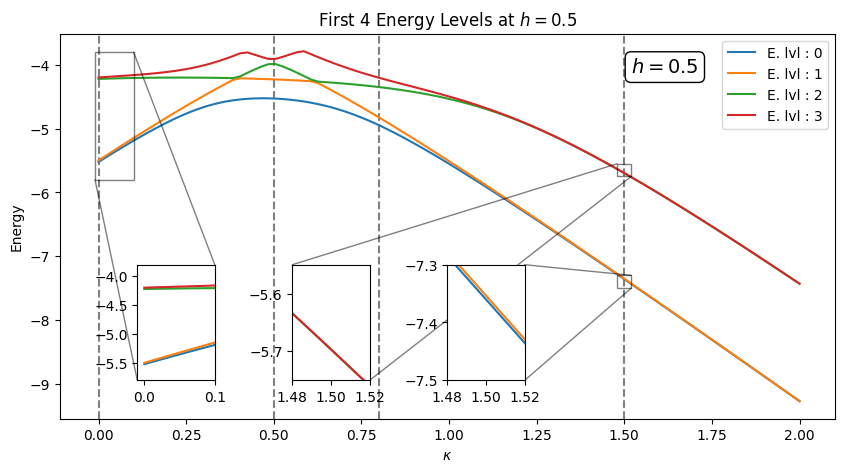

In [154]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

ax.axvline(x=0.0, ls='--', color='gray'); ax.axvline(x=0.5, ls='--', color='gray'); ax.axvline(x=0.8, ls='--', color='gray'); ax.axvline(x=1.5, ls='--', color='gray')
ax.plot(np.abs(kappas), E0, label = f'E. lvl : {0}'); ax.plot(np.abs(kappas), E1, label = f'E. lvl : {1}')
ax.plot(np.abs(kappas), E2, label = f'E. lvl : {2}'); ax.plot(np.abs(kappas), E3, label = f'E. lvl : {3}')
inset = ax.inset_axes(bounds=[0.1, 0.1, 0.1, 0.3])
inset.set_xlim([-0.01,0.1]); inset.set_ylim([-5.8,-3.8])
ax.indicate_inset_zoom(inset, edgecolor="black", zorder=5)
inset.plot(np.abs(kappas), E0); inset.plot(np.abs(kappas), E1)
inset.plot(np.abs(kappas), E2); inset.plot(np.abs(kappas), E3)

inset1 = ax.inset_axes(bounds=[0.3, 0.1, 0.1, 0.3])
inset1.set_xlim([1.48,1.52]); inset1.set_ylim([-5.75,-5.55])
ax.indicate_inset_zoom(inset1, edgecolor="black", zorder=5)
inset1.plot(np.abs(kappas), E0); inset1.plot(np.abs(kappas), E1)
inset1.plot(np.abs(kappas), E2); inset1.plot(np.abs(kappas), E3)

inset2 = ax.inset_axes(bounds=[0.5, 0.1, 0.1, 0.3])
inset2.set_xlim([1.48,1.52]); inset2.set_ylim([-7.5,-7.3])
ax.indicate_inset_zoom(inset2, edgecolor="black", zorder=5)
inset2.plot(np.abs(kappas), E0); inset2.plot(np.abs(kappas), E1); inset2.plot(np.abs(kappas), E2); inset2.plot(np.abs(kappas), E3)

ax.set_xlabel(r'$\kappa$'); ax.set_ylabel('Energy')
ax.annotate(r'$h=0.5$', xy=(460, 260), xycoords='axes points', size=14, ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
ax.legend(); ax.set_title(r'First 4 Energy Levels at $h=0.5$')

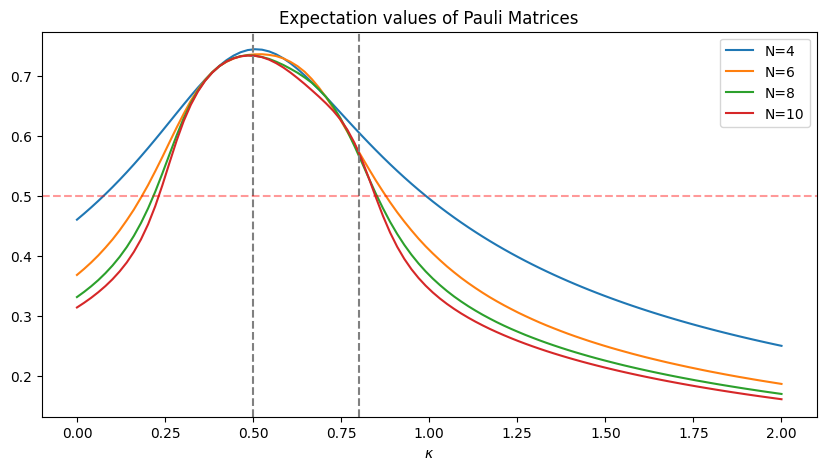

In [163]:
Ns = [4,6,8,10]

plt.figure(figsize=(10,5))
for n in Ns:
    Hs = []
    for k in kappas:
        Hs.append(get_H(n, .5, k))
    Hs = jnp.array(Hs)
    _, PSI0 = v_get_eigs(Hs,0)
    PSI0 = PSI0[:,:,0]
    plt.plot(np.abs(kappas), v_pauliZ(PSI0, 'Z'), label=f'N={n}')
plt.title('Expectation values of Pauli Matrices'); plt.xlabel(r'$\kappa$'); plt.legend(); plt.axvline(x=0.5,ls='--', color='gray'); plt.axvline(x=0.8,ls='--', color='gray'); plt.axhline(y=0.5, ls='--', color='red', alpha=0.4)